# Tutorial 9-1: The Universal Translator – "Seq2Seq with Attention"

**Course:** CSEN 342: Deep Learning  
**Topic:** Sequence-to-Sequence, Encoder-Decoder, and Bahdanau Attention

## Objective
In the lecture, we saw that standard RNNs struggle with long sequences because they must compress the entire input meaning into a single, fixed-size vector (the "bottleneck" problem).

**Attention** solves this by allowing the decoder to "look back" at the entire source sentence and focus on specific words at each step of generation.

In this tutorial, we will:
1.  **Load Real Translation Data:** Use the Tatoeba English-French dataset.
2.  **Build an Encoder:** A Bidirectional GRU to read the input.
3.  **Implement Bahdanau Attention:** Write the math for calculating alignment scores $e_{t,i}$ and attention weights $a_{t,i}$ from scratch.
4.  **Visualize Alignment:** Generate heatmaps showing which French words correspond to which English words.

---

## Part 1: Data Preparation (Tatoeba Dataset)

We will use a dataset of English-French sentence pairs from the Tatoeba project. It contains ~190k pairs. 
**Note:** We use `wget` to handle the download robustly on the cluster.

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import unicodedata
import re
import os
import zipfile

# 1. Robust Download
data_root = '../data'
os.makedirs(data_root, exist_ok=True)
txt_path = os.path.join(data_root, 'fra.txt')

if not os.path.exists(txt_path):
    print("Downloading English-French dataset...")
    url = "https://www.manythings.org/anki/fra-eng.zip"
    os.system(f"wget -nc -P {data_root} {url}")
    
    print("Unzipping...")
    with zipfile.ZipFile(os.path.join(data_root, 'fra-eng.zip'), 'r') as zip_ref:
        zip_ref.extractall(data_root)
    print("Done.")

# 2. Text Preprocessing Utilities
def unicode_to_ascii(s):
    # Normalizes accents (e.g., "é" -> "e") to simplify the vocab
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                   if unicodedata.category(c) != 'Mn')

def normalize_string(s):
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s) # Add space before punctuation
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s) # Remove non-alpha chars
    return s

def read_data(path, num_samples=30000):
    # Read lines
    with open(path, 'r', encoding='utf-8') as f:
        lines = f.read().strip().split('\n')
    
    # Split pairs (Eng, Fra)
    pairs = [[normalize_string(s) for s in l.split('\t')[:2]] for l in lines]
    
    # Filter: Keep only short sentences for easier training in this tutorial
    # (Max length 10 words, English starts with simple phrases)
    MAX_LENGTH = 10
    eng_prefixes = (
        "i am ", "i m ",
        "he is ", "he s ",
        "she is ", "she s ",
        "you are ", "you re ",
        "we are ", "we re ",
        "they are ", "they re "
    )
    
    filter_pairs = []
    for p in pairs:
        if len(p[0].split(' ')) < MAX_LENGTH and \
           len(p[1].split(' ')) < MAX_LENGTH and \
           p[0].startswith(eng_prefixes):
            filter_pairs.append(p)
            
    return filter_pairs

pairs = read_data(txt_path)
print(f"Loaded {len(pairs)} sentence pairs.")
print("Example:", pairs[0])

Loaded 16834 sentence pairs.
Example: ['i m .', 'j ai ans .']


### 1.2 Vocabulary Building
We need to convert words to integers. We need separate vocabularies for English and French.

In [4]:
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {"<SOS>": 0, "<EOS>": 1}
        self.index2word = {0: "<SOS>", 1: "<EOS>"}
        self.n_words = 2

    def add_sentence(self, sentence):
        for word in sentence.split(' '):
            self.add_word(word)

    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.index2word[self.n_words] = word
            self.n_words += 1

input_lang = Lang("eng")
output_lang = Lang("fra")

for pair in pairs:
    input_lang.add_sentence(pair[0])
    output_lang.add_sentence(pair[1])

print(f"English Vocab: {input_lang.n_words} words")
print(f"French Vocab: {output_lang.n_words} words")

English Vocab: 3612 words
French Vocab: 5547 words


---

## Part 2: The Encoder (Bidirectional RNN)

We use a GRU (Gated Recurrent Unit), which is a simplified LSTM. 

**Bidirectional:** We process the sentence forward ($x_1 \to x_T$) and backward ($x_T \to x_1$). This allows the encoder to capture context from both sides. The final output for each word is the concatenation of its forward and backward hidden states.



In [5]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True, bidirectional=True)

    def forward(self, input):
        # input: (Batch, Seq_Len)
        embedded = self.embedding(input)
        output, hidden = self.gru(embedded)
        # Output: (Batch, Seq_Len, 2*Hidden) -> Concatenated Forward+Backward features
        # Hidden: (2*Layers, Batch, Hidden) -> Final states
        return output, hidden

---

## Part 3: The Attention Mechanism

This is the most critical part. We implement **Additive Attention** (Bahdanau et al.).

**Goal:** Calculate a "Context Vector" $c_t$ for the current decoder step $t$.

**Steps:**
1.  **Calculate Alignment Scores ($E$):** Compare the Decoder's current hidden state ($s_{t-1}$) with *every* Encoder hidden state ($h_1 ... h_T$).
    $$ e_{t,i} = v_a^T \tanh(W_a s_{t-1} + U_a h_i) $$
2.  **Calculate Attention Weights ($A$):** Normalize scores using Softmax.
    $$ a_{t,i} = \text{softmax}(e_{t,i}) $$
3.  **Compute Context Vector ($C$):** Weighted sum of encoder states.
    $$ c_t = \sum_i a_{t,i} h_i $$

In [6]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        # We need to project both decoder state and encoder states to a common dimension
        self.W_a = nn.Linear(hidden_size, hidden_size)  # For Decoder state (s_{t-1})
        self.U_a = nn.Linear(hidden_size * 2, hidden_size) # For Encoder states (h_i) (x2 because bidirectional)
        self.v_a = nn.Linear(hidden_size, 1, bias=False) # Scoring vector v_a

    def forward(self, decoder_hidden, encoder_outputs):
        # decoder_hidden: (Batch, Hidden)
        # encoder_outputs: (Batch, Seq_Len, 2*Hidden)
        
        # 1. Expand decoder hidden to match seq_len dimension for addition
        # (Batch, 1, Hidden)
        query = self.W_a(decoder_hidden).unsqueeze(1)
        
        # 2. Project encoder outputs
        # (Batch, Seq_Len, Hidden)
        keys = self.U_a(encoder_outputs)
        
        # 3. Calculate Scores (Additive)
        # tanh(Wa * s + Ua * h)
        energy = torch.tanh(query + keys) 
        
        # v_a^T * energy -> (Batch, Seq_Len, 1)
        scores = self.v_a(energy)
        
        # 4. Attention Weights (Softmax over Seq_Len dim)
        attn_weights = F.softmax(scores, dim=1)
        
        # 5. Context Vector (Weighted Sum)
        # (Batch, 1, Seq_Len) * (Batch, Seq_Len, 2*Hidden) -> (Batch, 1, 2*Hidden)
        context_vector = torch.bmm(attn_weights.transpose(1, 2), encoder_outputs)
        
        return context_vector, attn_weights

## Part 4: The Decoder

The decoder takes the **Context Vector** and the **Previous Word Embedding** to predict the next word.

In [11]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        
        self.gru = nn.GRU(hidden_size * 3, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input_word, hidden, encoder_outputs):
        # 1. Get Embedding
        # We force the shape to be (1, 1, Hidden) using .view()
        # This handles both cases: 
        #   Case A: input_word is (1, 1) -> embedding is (1, 1, Hidden)
        #   Case B: input_word is (1,)   -> embedding is (1, Hidden) -> view -> (1, 1, Hidden)
        embedded = self.embedding(input_word).view(1, 1, -1)
        
        # 2. Calculate Attention
        query_hidden = hidden.squeeze(0)
        context, attn_weights = self.attention(query_hidden, encoder_outputs)
        
        # 3. Combine Embedding and Context
        # Now both 'embedded' and 'context' are guaranteed to be 3D
        rnn_input = torch.cat((embedded, context), dim=2)
        
        # 4. GRU Step
        output, hidden = self.gru(rnn_input, hidden)
        
        # 5. Predict Word
        prediction = self.out(output.squeeze(1))
        
        return prediction, hidden, attn_weights

---

## Part 5: Training and Visualization

We will train on a small batch of data and visualize the attention matrix.

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HIDDEN_SIZE = 256

encoder = EncoderRNN(input_lang.n_words, HIDDEN_SIZE).to(device)
decoder = AttnDecoderRNN(HIDDEN_SIZE, output_lang.n_words).to(device)

enc_optimizer = optim.Adam(encoder.parameters(), lr=0.001)
dec_optimizer = optim.Adam(decoder.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Prepare Tensors
def tensorFromSentence(lang, sentence):
    indexes = [lang.word2index[word] for word in sentence.split(' ')]
    indexes.append(1) # EOS
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

# Simple training loop for one pair (SGD style for clarity)
def train(input_tensor, target_tensor):
    enc_optimizer.zero_grad()
    dec_optimizer.zero_grad()
    
    # 1. Encode
    # Reshape to (Batch=1, Seq)
    input_batch = input_tensor.transpose(0, 1)
    encoder_outputs, encoder_hidden = encoder(input_batch)
    
    # 2. Prepare Decoder
    # Decoder hidden starts as Encoder's last hidden state
    # Note: Encoder is bidirectional (2 layers of hidden), Decoder is unidirectional (1)
    # We sum the forward/backward states to initialize decoder
    decoder_hidden = encoder_hidden[0, :, :] + encoder_hidden[1, :, :]
    decoder_hidden = decoder_hidden.unsqueeze(0)
    
    decoder_input = torch.tensor([[0]], device=device) # <SOS>
    
    loss = 0
    target_len = target_tensor.size(0)
    
    # 3. Decode Loop
    for di in range(target_len):
        decoder_output, decoder_hidden, attn_weights = decoder(
            decoder_input, decoder_hidden, encoder_outputs)
        
        loss += criterion(decoder_output, target_tensor[di])
        decoder_input = target_tensor[di] # Teacher Forcing
        
    loss.backward()
    enc_optimizer.step()
    dec_optimizer.step()
    return loss.item() / target_len

# Train on 20,000 random pairs
# This will take a few minutes, but it's necessary for the attention to work.
n_iters = 20000
print_every = 1000
plot_every = 100

print("Training...")
import random
import time

start_time = time.time()
total_loss = 0

for i in range(1, n_iters + 1):
    pair = random.choice(pairs)
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    
    loss = train(input_tensor, target_tensor)
    total_loss += loss

    if i % print_every == 0:
        avg_loss = total_loss / print_every
        total_loss = 0
        print(f"Iter {i} ({i/n_iters*100:.1f}%) Loss: {avg_loss:.4f}")

print("Training Complete.")


Training...
Iter 1000 (5.0%) Loss: 3.6284
Iter 2000 (10.0%) Loss: 2.9001
Iter 3000 (15.0%) Loss: 2.6302
Iter 4000 (20.0%) Loss: 2.3941
Iter 5000 (25.0%) Loss: 2.2448
Iter 6000 (30.0%) Loss: 2.1651
Iter 7000 (35.0%) Loss: 2.0225
Iter 8000 (40.0%) Loss: 1.8922
Iter 9000 (45.0%) Loss: 1.9195
Iter 10000 (50.0%) Loss: 1.7539
Iter 11000 (55.0%) Loss: 1.7138
Iter 12000 (60.0%) Loss: 1.7376
Iter 13000 (65.0%) Loss: 1.6764
Iter 14000 (70.0%) Loss: 1.6312
Iter 15000 (75.0%) Loss: 1.5956
Iter 16000 (80.0%) Loss: 1.5336
Iter 17000 (85.0%) Loss: 1.5996
Iter 18000 (90.0%) Loss: 1.5465
Iter 19000 (95.0%) Loss: 1.5778
Iter 20000 (100.0%) Loss: 1.5209
Training Complete.


### 5.1 Visualize Attention

We will translate a sentence and record the attention weights at each step to see *where* the model looks.

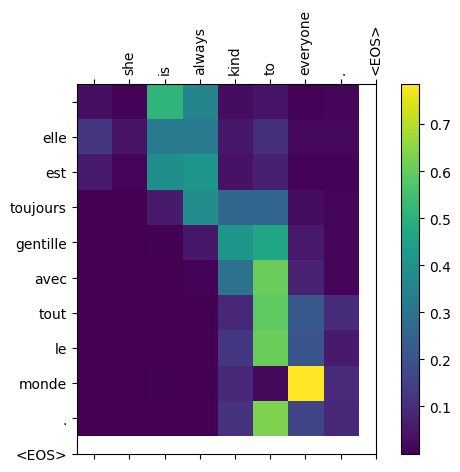

Input: she is always kind to everyone .
Output: elle est toujours gentille avec tout le monde . <EOS>


In [18]:
def evaluate_and_show_attention(sentence):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_batch = input_tensor.transpose(0, 1)
        encoder_outputs, encoder_hidden = encoder(input_batch)
        
        decoder_hidden = encoder_hidden[0, :, :] + encoder_hidden[1, :, :]
        decoder_hidden = decoder_hidden.unsqueeze(0)
        decoder_input = torch.tensor([[0]], device=device)
        
        decoded_words = []
        attentions = []
        
        for di in range(10): # Max length
            decoder_output, decoder_hidden, attn_weights = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            
            # Store attention weights (1, 1, Seq_Len)
            attentions.append(attn_weights.squeeze().cpu().numpy())
            
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == 1: # EOS
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])
            decoder_input = topi.detach()
            
        # Plotting
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(np.array(attentions))
        fig.colorbar(cax)
        
        # Prepare labels
        x_labels = [''] + sentence.split(' ') + ['<EOS>']
        y_labels = [''] + decoded_words
        
        # --- FIX: Set tick positions explicitly first ---
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
        
        ax.set_xticks(np.arange(len(x_labels)))
        ax.set_yticks(np.arange(len(y_labels)))
        
        # Now set the labels
        ax.set_xticklabels(x_labels, rotation=90)
        ax.set_yticklabels(y_labels)
        
        plt.show()
        print(f"Input: {sentence}")
        print(f"Output: {' '.join(decoded_words)}")

# Pick a random training pair to see if it memorized it correctly
pair = random.choice(pairs)
evaluate_and_show_attention(pair[0])

### Conclusion
If the model trained well, you should generally see a diagonal trend, indicating the decoder is progressing through the sentence. However, **do not expect a perfect diagonal line**.

The power of the Attention mechanism is its ability to handle non-monotonic alignments—situations where the word order flips between languages.
- **Adjective-Noun Inversion**: In English, we say "Red House" (Adjective $\to$ Noun). In French, it is often "Maison Rouge" (Noun $\to$ Adjective).
- **The Visualization**: In these cases, you should see the attention "look ahead" to the noun first, and then "look back" to the adjective, creating a break or distinct swap in the diagonal pattern.

This heatmap proves that the model isn't just translating word-for-word index-by-index, but is actively searching for the semantically relevant English word required to generate the next French word, regardless of its position.